ideas: 
* https://ijarsct.co.in/Paper4350.pdf

* https://sahilvaidya99.medium.com/spoiler-detection-in-movie-reviews-51312d6146ef
* https://www.sas.com/content/dam/SAS/support/en/sas-global-forum-proceedings/2020/5012-2020.pdf (86% accuracy)

# Data preparing

In [ ]:
# https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset

import json
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

df_movie_details = pd.read_json('/content/drive/My Drive/CS3244 project/IMDB_movie_details.json', lines = True)
df_reviews = pd.read_json('/content/drive/My Drive/CS3244 project/IMDB_reviews.json', lines = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# If using jupyter notebook
import json
import pandas as pd

df_movie_details = pd.read_json('IMDB_movie_details.json', lines = True)
df_reviews = pd.read_json('IMDB_reviews.json', lines = True)

In [ ]:
print('User reviews shape: ', df_reviews.shape)
print(df_reviews.info())
df_reviews.head(10)

We have a total of 573,913 user reviews. <br>
Each review comes with a label True or False depending on the spoiler content in the review.

In [ ]:
print('Movie details shape: ', df_movie_details.shape)
print(df_movie_details.info())
df_movie_details.head(10)

We have a total of 1572 movies.

## Datasets merging

In [ ]:
# remove '/' in the movie_id 

df_movie_details['movie_id'] = df_movie_details['movie_id'].str.replace('/', '')
df_movie_details['movie_id']

0       tt0105112
1       tt1204975
2       tt0243655
3       tt0040897
4       tt0126886
          ...    
1567    tt0289879
1568    tt1723811
1569    tt5013056
1570    tt0104014
1571    tt0114142
Name: movie_id, Length: 1572, dtype: object

We merge the two datasets.

In [ ]:
df = pd.merge(df_reviews, df_movie_details, on = 'movie_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573913 entries, 0 to 573912
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review_date     573913 non-null  object 
 1   movie_id        573913 non-null  object 
 2   user_id         573913 non-null  object 
 3   is_spoiler      573913 non-null  bool   
 4   review_text     573913 non-null  object 
 5   rating_x        573913 non-null  int64  
 6   review_summary  573913 non-null  object 
 7   plot_summary    573913 non-null  object 
 8   duration        573913 non-null  object 
 9   genre           573913 non-null  object 
 10  rating_y        573913 non-null  float64
 11  release_date    573913 non-null  object 
 12  plot_synopsis   573913 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 57.5+ MB


In [ ]:
df.head()

Change the column names. <br>
rating_x -> user_rating <br>
rating_y -> movie_rating <br>

In [ ]:
df.rename(columns = {'rating_x': 'user_rating', 'rating_y': 'movie_rating'}, inplace = True)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


## Dataset analysis

We find the number of reviews per each movie.

In [ ]:
import seaborn as sns

sns.countplot(data = df, x = 'movie_id', order = df['movie_id'].value_counts().index)

df['movie_id'].value_counts()

We realised that some movies have a large number of reviews (more than 2000) while some movies have less than 10 reviews. <br>

We may consider to filter out movies with less than 300 reviews.

Find the distribution between classes. 
(spoiler or non-spoiler)

In [ ]:
import matplotlib.pyplot as plt

spoiler_count = df.is_spoiler.value_counts(normalize = True) * 100

print(spoiler_count)

spoiler_count.plot(kind = 'bar')
plt.title('is spoiler')
plt.show()

The dataset seems to be imbalanced. <br>
Percentage of spoilers = 26.3% <br>
Percentage of non-spoilers = 73.7% <br>

We have twice the number of non-spoilers than spoliers. <br>

We have to do something about it (undersampling / oversampling) before we can train our model. <br>

# Data processing

Fisrt, we will check for missing data.

In [ ]:
count = df_reviews.isnull().sum().sort_values(ascending = False)
percentage = ((df_reviews.isnull().sum() / len(df_reviews) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count', 'Percentage'])

print('Missing data in user reviews dataset')
print(missing_data)

From the output above, there is no missing value in the user reviews dataset.

In [ ]:
count = df_movie_details.isnull().sum().sort_values(ascending = False)
percentage = ((df_movie_details.isnull().sum() / len(df_movie_details) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count','Percentage'])

print('Missing data in movie details dataset')
print(missing_data)

From the above output, we do not have missing value for the movie details dataset too.

In [ ]:
count = df.isnull().sum().sort_values(ascending = False)
percentage = ((df.isnull().sum() / len(df) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count','Percentage'])

print('Missing data in merged dataset')
print(missing_data)

Find if there is any relationship between the user ratings and spoiler by plotting a bar graph.

In [ ]:
import matplotlib.pyplot as plt

group = df.groupby('user_rating')

group_is_spoiler = df[df['is_spoiler'] == True].groupby('user_rating')
total_review_for_vote = group.size() # Get the number of reviews foreach vote
total_spoiler_for_vote = group_is_spoiler.size() # Get the number of spoiler review foreach vote
percentage = ((total_spoiler_for_vote / total_review_for_vote) * 100)

# Print % graph

y_axis = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x_axis = percentage.tolist()

plt.barh(y_axis, x_axis,color = ['red','cyan','blue','purple','lime','magenta','orange','brown','silver','Green'])
plt.xlim(0,100)
plt.title('Percentage of spoiler reviews per user rating')
plt.ylabel('User Ratings')
plt.xlabel('Percentages')
plt.show()

From the above bar graph, it seems that lower user ratings have a higher spoiler rate.

Find is there is any relationship between movie rating and spoilers.

In [ ]:
import seaborn as sns

group = df.groupby('movie_rating')
group_is_spoiler = df[df['is_spoiler'] == True].groupby('movie_rating')

total_review_for_vote = group.size()        
total_spoiler_for_vote = group_is_spoiler.size()   
percentage = ((total_spoiler_for_vote / total_review_for_vote) * 100)

# plt.barh(df['movie_rating'].unique(), percentage)
# plt.xlim(0, 100)
# plt.title('Percentage of spoiler reviews per movie rating')
# plt.ylabel('Movie Ratings')
# plt.xlabel('Percentages')
# plt.show()

# plt.hist(percentage, density = True)

sns.histplot(data = df, x = 'movie_rating', hue = 'is_spoiler', multiple = 'stack')

Analysis the review_text columns. <br>
Identify the reviews that contains the word 'spoiler' and find the relationship between spoilers.

In [ ]:
def contains_word(word, df):
  col_name = 'contains_word_' + word
  df[col_name] = df['review_text'].apply(lambda text: word in text.upper())
  return df

In [ ]:
df = contains_word('SPOILER', df)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",False
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",False
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",False
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",False


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_of_spoiler = df[df['is_spoiler'] == True].shape[0]
num_of_spoiler_with_spoiler_word = df[(df['is_spoiler'] == True) & (df['contains_word_SPOILER'] == True)].shape[0]
num_of_non_spoiler_with_spoiler_word = df[(df['is_spoiler'] == False) & (df['contains_word_SPOILER'] == True)].shape[0]
num_of_reviews_with_spoiler_word = df[df['contains_word_SPOILER'] == True].shape[0]

# plot 2 pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15)) 
fig.tight_layout(pad = 10.0)

labels = ['Spoiler', 'Non-spoiler']
values = np.array([(num_of_spoiler_with_spoiler_word / num_of_reviews_with_spoiler_word) * 100,
           (num_of_non_spoiler_with_spoiler_word / num_of_reviews_with_spoiler_word) * 100])
ax1.pie(values, labels = labels, colors = ['#ff9999','#66b3ff'], autopct = '%1.2f%%')
ax1.set_title('Reviews containing the word spoiler')

labels = ['Containing the word spoiler', 'Not containing the word spoiler']
values = np.array([(num_of_spoiler_with_spoiler_word / num_of_spoiler) * 100,
           ((num_of_spoiler - num_of_spoiler_with_spoiler_word) / num_of_spoiler) * 100])
ax2.pie(values,labels = labels, colors = ['#ff9999', '#ffcc99'],autopct = '%1.2f%%') #plot second pie
ax2.set_title('Spoiler reviews')

From the pie charts above, for the reviews that contain the word 'spoiler', 71.9% are spoilers and 24.1% are non-spoilers. <br>

Out of the all spoilers' reviews, only 12.6% conatains the word spoiler. 87.4% of the spoiler reviews do not contain the word spoiler.

## Picking a Movie

In [ ]:
def pick_movie(movie_id):
  global df
  df = df.loc[df['movie_id'] == movie_id, :]

In [ ]:
pick_movie('tt0468569')

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER
0,20 July 2008,tt0468569,ur1293485,True,I got to see The Dark Knight on Wednesday nigh...,10,The Batman of our dreams! So much more than a ...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
1,16 July 2008,tt0468569,ur13846894,True,I must say I was excited for this movie since ...,10,Certainly Dark - Worth The Wait,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
2,16 July 2008,tt0468569,ur2371300,True,I thought Batman Begins was a very well concei...,10,Best. Comic. Movie. EVER.,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
3,16 July 2008,tt0468569,ur5237888,True,I think the big question...or the question eve...,10,The Dark Knight is as good as everyone says an...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
4,17 July 2008,tt0468569,ur2747265,True,(Synopsis) Bruce Wayne/Batman (Christian Bale)...,10,The dark and sinister mood of the film really ...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            4845 non-null   object 
 1   movie_id               4845 non-null   object 
 2   user_id                4845 non-null   object 
 3   is_spoiler             4845 non-null   bool   
 4   review_text            4845 non-null   object 
 5   user_rating            4845 non-null   int64  
 6   review_summary         4845 non-null   object 
 7   plot_summary           4845 non-null   object 
 8   duration               4845 non-null   object 
 9   genre                  4845 non-null   object 
 10  movie_rating           4845 non-null   float64
 11  release_date           4845 non-null   object 
 12  plot_synopsis          4845 non-null   object 
 13  contains_word_SPOILER  4845 non-null   bool   
dtypes: bool(2), float64(1), int64(1), object(10)
memory usag

## Under-sampling

This is done before data cleaning.

In [ ]:
def under_sampling():
    global df
    df_0 = df[df['is_spoiler'] == False]
    df_1 = df[df['is_spoiler'] == True]
    sample_size = df_1.shape[0]
    df_0 = df_0.sample(sample_size)
    df = pd.concat([df_0, df_1])


In [ ]:
under_sampling()

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER
0,30 June 2002,tt0167404,ur1821533,False,"I saw this film in the U.S. when I was there, ...",10,M. Night Shyamalan - remember that name!,Malcom Crowe (Bruce Willis)is a child psycholo...,1h 47min,"[Drama, Mystery, Thriller]",8.1,1999-08-06,"Dr. Malcolm Crowe (Bruce Willis), a prominent ...",False
1,27 July 2015,tt1937390,ur0278527,False,Apparently this film has received considerable...,5,"So, I Saw This Title on Netflix.....",A man named Seligman finds a fainted wounded w...,1h 57min,[Drama],7.0,2014-03-06,The film starts with a repetitive sound effect...,False
2,26 December 2016,tt4550098,ur56801091,False,"Well, after Amy Adams picking this flop and th...",2,"Little hope for Adams' ""Dis-Enchanted""","A ""story inside a story,"" in which the first p...",1h 56min,"[Crime, Drama, Romance]",7.5,2016-12-09,"The movie begins with obese women, dancing nak...",False
3,3 November 2007,tt0765429,ur5118543,False,"When I first heard about this film, I was hope...",5,Irresponsible and Dull,Following the death of his employer and mentor...,2h 37min,"[Biography, Crime, Drama]",7.8,2007-11-02,The film opens with Bumpy Johnson (Clarence Wi...,False
4,3 March 2007,tt0443706,ur6663090,False,"After having read other critiques, I will conc...",9,A fresh take on the elusive serial killer....,A serial killer in the San Francisco Bay Area ...,2h 37min,"[Crime, Drama, History]",7.7,2007-03-02,"The film starts on July 4, 1969, with the Zodi...",False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301848 entries, 0 to 301847
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   review_date            301848 non-null  object 
 1   movie_id               301848 non-null  object 
 2   user_id                301848 non-null  object 
 3   is_spoiler             301848 non-null  bool   
 4   review_text            301848 non-null  object 
 5   user_rating            301848 non-null  int64  
 6   review_summary         301848 non-null  object 
 7   plot_summary           301848 non-null  object 
 8   duration               301848 non-null  object 
 9   genre                  301848 non-null  object 
 10  movie_rating           301848 non-null  float64
 11  release_date           301848 non-null  object 
 12  plot_synopsis          301848 non-null  object 
 13  contains_word_SPOILER  301848 non-null  bool   
dtypes: bool(2), float64(1), int64(1), ob

False    50.0
True     50.0
Name: is_spoiler, dtype: float64


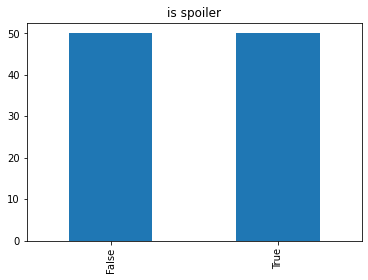

In [ ]:
import matplotlib.pyplot as plt
spoiler_count = df.is_spoiler.value_counts(normalize = True) * 100

print(spoiler_count)

spoiler_count.plot(kind = 'bar')
plt.title('is spoiler')
plt.show()

Now the dataset is balanced!

## Size Reduction

In [ ]:
def reduce_data_size():
    global df
    frac = 0.1
    df = df.sample(frac=frac)

In [ ]:
reduce_data_size()

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30185 entries, 0 to 30184
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            30185 non-null  object 
 1   movie_id               30185 non-null  object 
 2   user_id                30185 non-null  object 
 3   is_spoiler             30185 non-null  bool   
 4   review_text            30185 non-null  object 
 5   user_rating            30185 non-null  int64  
 6   review_summary         30185 non-null  object 
 7   plot_summary           30185 non-null  object 
 8   duration               30185 non-null  object 
 9   genre                  30185 non-null  object 
 10  movie_rating           30185 non-null  float64
 11  release_date           30185 non-null  object 
 12  plot_synopsis          30185 non-null  object 
 13  contains_word_SPOILER  30185 non-null  bool   
dtypes: bool(2), float64(1), int64(1), object(10)
memory us

## Data Cleaning

In [ ]:
import re
def removeLinks(text):
  return re.sub(r'http\S+', '', text)
print(removeLinks('here is a link: https://google.com'))

here is a link: 


First, we will remove the links in the review_text column.

In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = removeLinks(df.at[i, 'review_text'])

Next, we will expand contraction words.

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 25.9 MB/s 


In [ ]:
import contractions
def expandContractions(text):
  expandedWords = []
  for word in text.split():
    expandedWords.append(contractions.fix(word))  
  return ' '.join(expandedWords)
print(expandContractions('I\'ve completed this function'))

I have completed this function


In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = expandContractions(df.at[i, 'review_text'])

Then, we do stopwords removal.



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Stop words removal
# Stemming
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop_words_set = set(stopwords.words('english'))
def myAnalyzer(text):
  text_words = analyzer(text)
  words = []
  for word in text_words:
    stemmed_word = stemmer.stem(word)
    # if stemmed_word not in stop_words_set:
    #   words.append(stemmed_word)
    words.append(stemmed_word)
  return words

We will count the total number of words left in each review text. Before counting the words, we need to remove all the special character.

In [ ]:
import string

def remove_special_character(sentence):
  pattern = r"[^a-zA-Z]"
  sentence = re.sub(pattern, ' ', sentence)
  return sentence

def word_count(sentence):
  num = len(sentence.split())
  # num = sum([i.strip(string.punctuation).isalpha() for i in sentence.split()])
  return num

In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = remove_special_character(df.at[i, 'review_text'])
  df.at[i, 'review_text_word_count'] = word_count(df.at[i, 'review_text'])

df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER,review_text_word_count
0,7 February 2003,tt0208092,ur1937029,False,While its not as good as LSATSB it comes clos...,9,Cool movie,Turkish and his close friend/accomplice Tommy ...,1h 42min,"[Comedy, Crime]",8.3,2001-01-19,The film opens as we see boxing promoter Turki...,False,116.0
1,12 November 2013,tt1951264,ur43364424,False,OK so I have been going through these reviews ...,10,This is not about the Hunger Games!,Twelve months after winning the 74th Hunger Ga...,2h 26min,"[Action, Adventure, Mystery]",7.5,2013-11-22,Six months after winning the 74th Hunger Games...,False,325.0
2,8 May 2015,tt2661044,ur51687135,True,If you could get page the fact that only attra...,7,It's a nice show,The series is set 97 years after a devastating...,43min,"[Drama, Mystery, Sci-Fi]",7.8,2014-05-03,"Story is post nuclear, according to the narrat...",False,310.0
3,18 February 2000,tt0124315,ur0161567,False,My wife and I who are something is loved th...,10,From a couple of seniors,"Homer is an orphan in remote St. Cloud, Maine....",2h 6min,"[Drama, Romance]",7.4,2000-01-07,"Homer Wells (Tobey Maguire), an orphan, is the...",False,43.0
4,25 December 2017,tt0068646,ur81865706,True,I love this movie The continuation is also ex...,10,Love this,When the aging head of a famous crime family d...,2h 55min,"[Crime, Drama]",9.2,1972-03-24,"In late summer 1945, guests are gathered for t...",False,39.0


# Feature extracting

In [ ]:
review_text = df['review_text'].to_list()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
analyzer = TfidfVectorizer().build_analyzer()
vectorizer = TfidfVectorizer(analyzer=myAnalyzer, min_df=0.01)


In [ ]:
# test_vectorizer = TfidfVectorizer(analyzer=myAnalyzer)
# test_counts = test_vectorizer.fit_transform(('Here\'s not an example!!!',
#   'There is a man who loves study', 
#   'I\'ve been STUDYING',
#   'What is this iiii',
#   'I\'ve been tmr learning cooool',
#   'What is that tomorrow',
#   'It is an apple mans'))
# print(test_vectorizer.get_feature_names_out())
# print(test_counts.toarray())

In [ ]:
review_text_tfidf = vectorizer.fit_transform(review_text)

# Models

In [ ]:
import pandas as pd

In [ ]:
review_text_tfidf_df = pd.DataFrame(review_text_tfidf.toarray())
review_text_tfidf_df.head()

In [ ]:
labels = df['is_spoiler'].to_list()
print(len(labels))
print(review_text_tfidf_df.shape[0])

2964
2964


In [ ]:
review_text_tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964 entries, 0 to 2963
Columns: 12512 entries, 0 to 12511
dtypes: float64(12512)
memory usage: 282.9 MB


## SVM

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(review_text_tfidf_df, labels, train_size = 0.8)

In [ ]:
import numpy as np
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(x_train, y_train)

SVC()

In [ ]:
svc_clf.score(x_test, y_test)

0.6526138279932546

🤣